# **Big G Tracking**

The following code will track the light for the Big G experiment. This will give you a dataset of position versus time, which you can then use to fit a curve to. 

To run this notebook, download it and run it as a jupyter notebook using a local install of Anaconda. It is recommended that you set up a new conda environemnt with the correct packages to ensure that the notebook runs successfully. To do this, open a terminal (or Anaconda prompt) and run the following lines:

`conda create -n opencv python=3.7
conda activate opencv
pip install opencv-contrib-python==3.4.6.27
pip install matplotlib
pip install scipy
pip install notebook
pip install ipywidgets`

After this, make sure that you change the working direcotry to be the same as the directory that this notebook (and the video.mp4 file) is saved in. Details about chagning the working directory of the Anaconda prompt can be found [here](https://stackoverflow.com/questions/48304305/anaconda-python-change-anaconda-prompt-user-path). You will need to change the ```VIDEO_PATH``` variable in the second code cell to match the filename of your recorded video.

You can then start your notebook using:

```jupyter notebook BigGTracking.ipynb```

You only need to install the packages using pip once. If you want to come back to working on this notebook, then you only need to make sure the Anaconda prompt working directory is correct and activate the conda environment using:

`conda activate opencv`

You can then run the notebook as above.

Note: When installing opencv with pip, make sure you install only the opencv-contrib-python library. Do not install opencv-python as well. This notebook works with python version 3.7 using opencv-contrib-python==3.4.6.27.


## **Setup programming environment**

Import the Python packages needed for our data analysis.

In [1]:
# Standard library imports
import os.path
import warnings
from time import time

# Third party imports
import cv2
from IPython.display import display, HTML
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
import numpy as np
from scipy.odr import ODR, RealData, Model
from uncertainties import ufloat
import uncertainties.umath as umath
import csv

Declare all our *global* variables. These are variables needed by multiple cells. They will be indicated using UPPER CASE letters.

In [2]:
VIDEO_PATH = 'video.mp4' # Path to the video file for analysis
FIRST_FRAME_IMAGE = None   # Image of the first video frame
U_DISTANCE = None          # Uncertain distance (in pixels) of the scale line
BOX = None                 # The bounding box for the object to be tracked
U_POSITION = None          # Uncertain position of the object tracker
FIT = None                 # The parameters for the curve fit to object tracking data

## **Preview video (optional)**

In [3]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(VIDEO_PATH))

## **Set the video scale**

This provides a plot in which a user can select endpoints of a line. This line should represent a known distance in the real world and will be used to translate movement in the video into accurate positional data.

Currently, the recommended way to draw the best line is to:
  1. turn on the zoom tool
  2. drag a box around the entire scale object
  3. turn off the zoom tool
  4. click one end of the scale object
  5. click the other end of the scale object

<IPython.core.display.Javascript object>


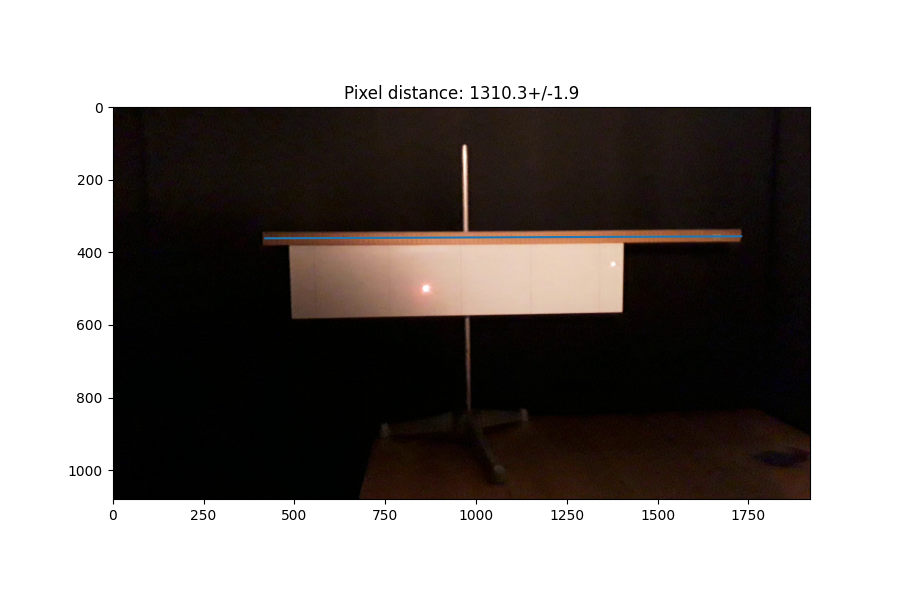

In [4]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(9,6))
ax.set_title('Pixel distance: ?')
line = ax.plot([0, 200], [0, 200])[0]
video = cv2.VideoCapture(VIDEO_PATH)
FIRST_FRAME_IMAGE = cv2.cvtColor(video.read()[1], cv2.COLOR_BGR2RGB) # Image of the first video frame
video.release()
ax.imshow(FIRST_FRAME_IMAGE)

switch = True

def onclickline(event): # this runs each mouse click
    global switch, U_DISTANCE
    # get current line
    (x0, x1), (y0, y1) = line.get_data()
    # alternate which endpoint of the line gets changed
    switch = not switch
    if switch: # change first point
        line.set_data([event.xdata, x1], [event.ydata, y1])
    else: # change second point
        line.set_data([x0, event.xdata], [y0, event.ydata])
    # get updated line data
    (x0, x1), (y0, y1) = line.get_data()
    # convert data coordinate (0,0) to display coordinate
    display_x, display_y = ax.transData.transform((0, 0))
    # convert display coordinate (1,1) to data coordinate
    ux, uy = ax.transData.inverted().transform((display_x+1, display_y+1))
    ux0 = ufloat(x0, abs(ux/2), "mouse_click_1x")
    uy0 = ufloat(y0, abs(uy/2), "mouse_click_1y")
    ux1 = ufloat(x1, abs(ux/2), "mouse_click_2x")
    uy1 = ufloat(y1, abs(uy/2), "mouse_click_2y")
    U_DISTANCE = umath.sqrt(umath.pow(ux1-ux0, 2) + umath.pow(uy1-uy0, 2))
    ax.set_title('Pixel distance: {}'.format(U_DISTANCE))
    fig.canvas.draw_idle()

cid = fig.canvas.mpl_connect('button_press_event', onclickline)
fig.canvas.draw()

Having drawn a scale line, this will ask the user what distance the line represents and will also ask for the uncertainty in this distance.

In [5]:
measure = float(input('The line drawn has a distance of {:.2f} pixels.\n'.format(U_DISTANCE.n)
                      + 'Tell me how many metres this should represent: '))
std_dev = float(input('What is the uncertainty of this length:'))
scale = ufloat(measure, std_dev, "scale_object_measurement") / U_DISTANCE
print('Each pixel will be {} metres.'.format(scale))

The line drawn has a distance of 1310.29 pixels.
Tell me how many metres this should represent: 1.02
What is the uncertainty of this length:0.02
Each pixel will be 0.000778+/-0.000015 metres.


## **Mark the object to be tracked**

The user should now create a bounding box around the object to be tracked. A plot will be presented with the first video frame displayed. Mouse clicks will alternate between relocating the upper left and lower right corners of the bounding box.

Currently, the recommended way to draw the best box is to:
  1. turn on the zoom tool
  2. drag a box around the object to be tracked
  3. turn off the zoom tool
  4. click the upper left corner of the desired bounding box
  5. click the lower right corner of the desired bounding box

<IPython.core.display.Javascript object>


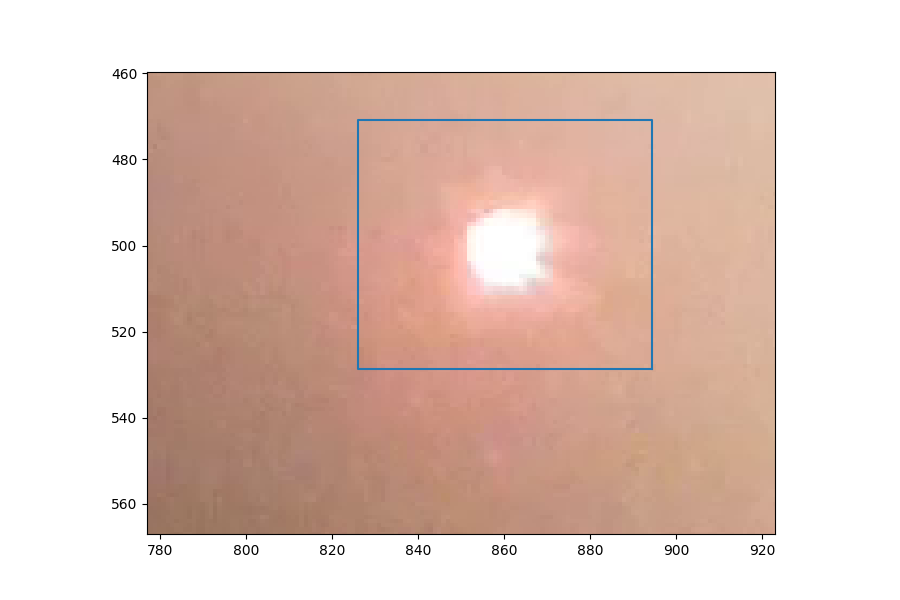

In [6]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(9,6))
BOX = ax.plot([200, 400, 400, 200, 200], [200, 200, 400, 400, 200])[0]
ax.imshow(FIRST_FRAME_IMAGE)

switch = True

def onclickbox(event):
    global switch, BOX
    xs, ys = BOX.get_data()
    if switch:
        BOX.set_data([event.xdata, xs[1], xs[2], event.xdata, event.xdata],
                     [event.ydata, event.ydata, ys[2], ys[3], event.ydata])
    else:
        BOX.set_data([xs[0], event.xdata, event.xdata, xs[3], xs[0]],
                     [ys[0], ys[1], event.ydata, event.ydata, ys[0]])
    switch = not switch
    fig.canvas.draw_idle()
    
cid = fig.canvas.mpl_connect('button_press_event', onclickbox)
fig.canvas.draw()

## **Perform object tracking**

The bounding box selected is fed into the object tracker and the position of the object inside the bounding box is recording through time.

A progress bar is provided to monitor the object tracking.

*Please do not move to the next step until object tracking completes. It will take several minutes.*

In [9]:
video = cv2.VideoCapture(VIDEO_PATH)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
progress = FloatProgress(min=0, max=total_frames)
display(progress)
try:
    fps = video.get(cv2.CAP_PROP_FPS)
    first_frame = video.read()[1]
    tracker = cv2.TrackerMIL_create()
    xs, ys = BOX.get_data()
    bbox = min(xs[0],xs[2]), min(ys[0],ys[2]), abs(xs[2]-xs[0]), abs(ys[2]-ys[0])
    bbox=tuple([int(i) for i in bbox])
    origin = ((2.0 * bbox[0] + bbox[2]) / 2.0,
              (2.0 * bbox[1] + bbox[3]) / 2.0)
    success = tracker.init(first_frame, bbox)
    if not success:
        raise RuntimeError('could not initialize tracker')
    frame_number = 0
    OBJECT_TRACKING_X = [ufloat(frame_number/fps, 0.5/fps, "time")]
    OBJECT_TRACKING_Y = [ufloat(0, scale.std_dev, "scale")]
    while True:
        success, frame = video.read()
        if not success:
            break
        frame_number += 1
        progress.value += 1
        success, bbox = tracker.update(frame)
        if success:
            distance = np.sqrt((((2.0 * bbox[0] + bbox[2]) / 2.0) - origin[0])**2
                               + (((2.0 * bbox[1] + bbox[3]) / 2.0) - origin[1])**2)
            OBJECT_TRACKING_X.append(ufloat(frame_number/fps, 0.5/fps, "time"))
            OBJECT_TRACKING_Y.append(distance * scale)
finally:
    video.release()
    del video

FloatProgress(value=0.0, max=822.0)

RuntimeError: could not initialize tracker

If the **progress bar above** is completely blue, You will now be able to plot the tracked object position against time.

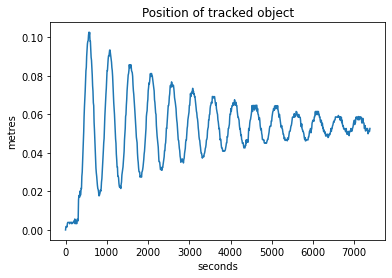

In [9]:
%matplotlib inline
# plot our object tracking data
plt.plot([x.n for x in OBJECT_TRACKING_X], [y.n for y in OBJECT_TRACKING_Y])
plt.title('Position of tracked object')
plt.xlabel('seconds')
plt.ylabel('metres')
plt.show()

Save the data to a csv file

In [10]:
with open('tracked_data.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Time (s)','Position (m)'])
    time = list([x.n for x in OBJECT_TRACKING_X])
    pos = list([y.n for y in OBJECT_TRACKING_Y])
    for i in range(len(time)):
        writer.writerow([time[i],pos[i]])